<a href="https://colab.research.google.com/github/17jmumford/ropewiki-scraper/blob/main/RopeWikiScraper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RopeWiki Scraper

## Description

This is a scraper designed to regularly export data from the open source website RopeWiki, a canyoneering database. This data will be integrated into the Canyoneer app on the Apple Store.

## Using this Scraper

### Parts that work well
Any user can run IMPORTS and GET CANYON DATA

### Experimental sections
KML data is still under construction

## To do
1. Finish KML data extraction and conversion
 * Loop through all KML files
 * Maybe explore alternative pulling method?
 * How to link back to PAGEID?
 * Modify GeoJson according to Brice's request
4. Determine how to integrate with Canyoneer
 * Lambda that puts data into public S3 bucket?

MediaWiki API Documentation
https://www.mediawiki.org/wiki/API:Main_page


## Imports

In [1]:
!sudo apt-get install gdal-bin libgdal-dev
!pip install pykml
!pip install geopandas lxml

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgdal-dev is already the newest version (3.4.3+dfsg-1~jammy0).
The following additional packages will be installed:
  python3-gdal python3-numpy
Suggested packages:
  libgdal-grass python-numpy-doc python3-pytest
The following NEW packages will be installed:
  gdal-bin python3-gdal python3-numpy
0 upgraded, 3 newly installed, 0 to remove and 9 not upgraded.
Need to get 4,968 kB of archives.
After this operation, 24.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 python3-numpy amd64 1:1.21.5-1ubuntu22.04.1 [3,467 kB]
Get:2 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy/main amd64 python3-gdal amd64 3.4.3+dfsg-1~jammy0 [967 kB]
Get:3 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy/main amd64 gdal-bin amd64 3.4.3+dfsg-1~jammy0 [534 kB]
Fetched 4,968 kB in 2s (2,754 kB/s)
debconf: unable to initialize fronten

In [2]:
import geopandas as gpd
from google.colab import files
from io import BytesIO
from io import StringIO
import matplotlib.pyplot as plt
import pandas as pd
from pykml import parser
import re
import requests
import seaborn as sns
from lxml import etree
from lxml import objectify
import json

# Get canyon data

## Pull base csv and clean

In [11]:
# Note: this method of iterating through regions is janky. Unfortunately the offset does not seem to work, so this is the best for now...
base_url = "https://ropewiki.com/index.php?title=Special:Ask&x=-5B-5BCategory%3ACanyons-5D-5D-5B-5BCategory%3ACanyons-5D-5D-5B-5BLocated-20in-20region.Located-20in-20regions%3A%3AX-7C-7C{}-5D-5D%2F-3FHas-20pageid%3DPAGEID%2F-3FHas-20name%3DLocation%2F-3FHas-20coordinates%3DCoords%2F-3FLocated-20in-20region%3DRegion%2F-3FHas-20user-20rating%3DQuality%2F-3FHas-20rating%3DRating%2F-3FHas-20time-20rating%3DTime-20Rating%2F-3FHas-20technical-20rating%3DTechnical-20Rating%2F-3FHas-20water-20rating%3DWater-20Rating%2F-3FHas-20extra-20risk-20rating%3DRisk-20Rating%2F-3FHas-20fastest-20typical-20time%3DMin-20Time%2F-3FHas-20slowest-20typical-20time%3DMax-20Time%2F-3FHas-20length-20of-20hike%3DHike%2F-3FRequires-20permits%3DPermits%2F-3FHas-20info-20rappels%3DRappels%2F-3FHas-20url%3DURL%2F-3FHas-20longest-20rappel%3DLongest%2F-3FHas-20best-20month%3DBest-20Months%2F-3FHas-20shuttle-20length%3DShuttle%2F-3FHas-20vehicle-20type%3DVehicle&format=csv&limit=2000&sort=Has_rank_rating%2C%20Has_name&order=descending%2C%20ascending&mainlabel=-&offset=0"

regions = ['Asia','Central America','Albania','Austria','Bavaria','Friuli Venezia Giulia','Lombardia','Piemonte',"Provence-Alpes-Cote d'Azur",'Slovenia','Switzerland','Trentino-Alto Adige',"Valle d'Aosta",'Andorra','Bulgaria','Croatia','France','Germany','Greece','Hungary','Iceland','Ireland','Islas Canarias','Italy','Lithuania','Macedonia','Montenegro','Poland','Portugal','Romania','Slovakia','Spain','Turkey','United Kingdom','Middle East','North America','Canada','Mexico','Northeast','Pacific Northwest','Alaska','Arizona','Arkansas','California','Central Utah','Colorado','Connecticut','Georgia','Hawaii','Idaho','Maine','Massachusetts','Montana','Nevada','New Mexico','New York','North Carolina','Oregon','South Carolina','South Dakota','Texas','Utah','Virginia','Washington','West Desert','Wyoming','Pacific','South America','Argentina','Bolivia','Brazil','Chile','Colombia','Ecuador','Peru','Playa Montezuma','Venezuela']
everything_df = pd.DataFrame()

for region in regions:
    # Format the URL with the current offset
    url = base_url.format(region)
    try:
      response = requests.get(url)
    except Exception as e:
      print("error while hitting ropewiki" + e)
      raise("error while hitting ropewiki" + e)

    # Check if the request was successful
    if response.status_code == 200:
        # If successful, get the text representation of the CSV
        csv_data = response.text
        data = pd.read_csv(StringIO(csv_data))
        everything_df = pd.concat([everything_df, data])
        print(region, end=" ")
    else:
        print("Failed to download CSV")
        break

Asia Central America Albania Austria Bavaria Friuli Venezia Giulia Lombardia Piemonte Provence-Alpes-Cote d'Azur Slovenia Switzerland Trentino-Alto Adige Valle d'Aosta Andorra Bulgaria Croatia France Germany Greece Hungary Iceland Ireland Islas Canarias Italy Lithuania Macedonia Montenegro Poland Portugal Romania Slovakia Spain Turkey United Kingdom Middle East North America Canada Mexico Northeast Pacific Northwest Alaska Arizona Arkansas California Central Utah Colorado Connecticut Georgia Hawaii Idaho Maine Massachusetts Montana Nevada New Mexico New York North Carolina Oregon South Carolina South Dakota Texas Utah Virginia Washington West Desert Wyoming Pacific South America Argentina Bolivia Brazil Chile Colombia Ecuador Peru Playa Montezuma Venezuela 

In [12]:
canyons_df = everything_df.copy(deep=True)
# remove non canyon pages. Drops it down to about 11,000 pages.

for remove in ['cav', 'POI', 'Via', 'Pit', 'Mine']:
  canyons_df = canyons_df[~canyons_df['Rating'].str.contains(remove, case=False, na=False)]

# remove 'ft' so it's just a number on Longest
canyons_df['Longest'] = pd.to_numeric(canyons_df['Longest'].str.replace(' ft', '').str.replace(',', ''), errors='coerce')

# drop canyons with null ratings and duplicates. Reduces count to about 6,700ish.
canyons_df_no_null_ratings = canyons_df.dropna(subset=['Rating'])
df_clean = canyons_df_no_null_ratings.drop_duplicates()
df_clean = df_clean.copy(deep=True)
# Splitting the 'Coords' column into two separate columns and assigning them

# Reset the index to avoid duplicate labels
df_clean.reset_index(drop=True, inplace=True)

df_clean[['Latitude', 'Longitude']] = df_clean['Coords'].str.split(',', expand=True)

# Converting the new columns to float using .loc for safe operation
df_clean['Latitude'] = df_clean['Latitude'].astype(float)
df_clean['Longitude'] = df_clean['Longitude'].astype(float)
# split into months
df_clean['Months'] = df_clean['Best Months'].str.split(',')

# Fill NaN values
df_clean['Rappels'].fillna('0r', inplace=True)

# Extract 'jump' values
df_clean['Jump'] = df_clean['Rappels'].str.extract(r'(\d+)j').fillna(0).astype(int)

# Extract rappel values
df_clean['rappel_values'] = df_clean['Rappels'].str.extract(r'(\d+-\d+|\d+|r)')[0].replace('r', '1-1')

# Split rappel values into 'min_rappel' and 'max_rappel'
df_clean[['Min Rappels', 'Max Rappels']] = df_clean['rappel_values'].str.split('-', expand=True).fillna(0).astype(int)
# make sure max_rappel never less than min_rappel
df_clean.loc[df_clean['Max Rappels'] < df_clean['Min Rappels'], 'Max Rappels'] = df_clean['Min Rappels']

# remove Ratings and Coords since we split it up into separate columns
df_export = df_clean.drop(columns=['Rating', 'Coords', 'Best Months', 'Rappels', 'rappel_values'])

## Add HTML to Dataframe and download



In [13]:
df_html = df_export.copy(deep=True)
# Add an empty 'HTMLDescription' column to df_export
df_html['HTMLDescription'] = [None] * len(df_html)

# Number of IDs to query at a time
chunk_size = 100

# Base URL for the request
base_url = 'http://ropewiki.com/api.php?action=query&export=true&pageids='

# Regex pattern to match everything between '==Introduction==' and '==Background==', inclusive
pattern = re.compile(r'==Introduction==.*?==Background==', re.DOTALL)

# Iterate through the PAGEIDs in chunks of 100
for i in range(0, len(df_html), chunk_size):
    # Get the current chunk of 100 PAGEIDs
    pageids_chunk = df_html['PAGEID'][i:i + chunk_size]
    print(". ", end="")
    # Concatenate the PAGEIDs with the '|' delimiter
    pageids_str = ' | '.join(map(str, pageids_chunk))

    # Construct the full URL
    url = base_url + pageids_str

    # Make the request
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # Use the regex pattern to find the required text
        matches = pattern.findall(response.text)

        # Store the extracted text in the dataframe
        for j, match in enumerate(matches):
            df_html.loc[i + j, 'HTMLDescription'] = match
    else:
        print(f"Request failed with status code {response.status_code}")

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [14]:
# download with HTML
df_html.to_csv('ropewiki_canyons_with_html.csv', index=False)
files.download('ropewiki_canyons_with_html.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Extra download options

In [ ]:
# download without HTML
df_export.to_csv('ropewiki_canyons_lat_long.csv', index=False)
files.download('ropewiki_canyons_lat_long.csv')

In [ ]:
# download unfiltered
everything_df.to_csv('ropewiki_canyons_unfiltered.csv', index=False)
files.download('ropewiki_canyons_unfiltered.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#download as JSON without html
json_data = df_export.to_dict(orient='records')
with open('ropewiki.json', 'w') as file:
    json.dump(json_data, file, indent=2)
files.download('ropewiki.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#download as JSON with html
json_data = df_html.to_dict(orient='records')
with open('ropewiki.json', 'w') as file:
    json.dump(json_data, file, indent=2)
files.download('ropewiki.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# KML experimentation

## Pull KML Data (experimental)

In [ ]:
# Define the path to your KML file
response = requests.get('https://ropewiki.com/luca/rwr?gpx=off&kml=http://ropewiki.com/index.php/KMLList?limit=100&offset=200&action=raw&templates=expand&ctype=application/x-zope-edit&num=on&numname=on&group=link&query=%5B%5BCategory%3ACanyons%5D%5D%5B%5BLocated%20in%20region.Located%20in%20regions%3A%3AX%7C%7CWorld%5D%5D&sort=Has_rank_rating%2C%20Has_name&order=descending%2C%20ascending&gpx=off&mapnum=&mapname=&mapdata=&maploc=&maplinks=&allmap=&qname=World&filename=World&ext=.kml')


In [ ]:
# Define the path to your KML file
# response = requests.get('https://ropewiki.com/luca/rwr?gpx=off&kml=http://ropewiki.com/index.php/KMLList?limit=200&action=raw&templates=expand&ctype=application/x-zope-edit&num=on&numname=on&group=link&query=%5B%5BCategory%3ACanyons%5D%5D%5B%5BLocated%20in%20region.Located%20in%20regions%3A%3AX%7C%7CWorld%5D%5D&sort=Has_rank_rating%2C%20Has_name&order=descending%2C%20ascending&gpx=off&mapnum=&mapname=&mapdata=&maploc=&maplinks=&allmap=&qname=World&filename=World&ext=.kml')

if response.status_code == 200:
  kml_file = BytesIO(response.content)
  kml_content = parser.parse(kml_file).getroot()
else:
    print(f"Request failed with status code {response.status_code}")

In [ ]:
# ----DEBUGGING STUFF-----
# children = kml_content.Document.getchildren()
# print(children[1].name)
# print(response.content)
# with open('raw_kml.txt', 'wb') as file:
#     file.write(kml_file)
# files.download('raw_kml.txt')

TypeError: ignored

In [ ]:
kml_files = []
i = 0
# Iterate through the folders containing the tracks
for child in kml_content.Document.getchildren():
    kml_file = etree.tostring(child, pretty_print=True).decode()
    title = child.name
    kml_files.append({'Title': title, 'File': kml_file})
kml_files.pop(0)
kml_files_df = pd.DataFrame(kml_files)

In [ ]:
kml_files_df.to_csv('kml_data_test_2.csv', index=False)
files.download('kml_data_test_2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Convert KML (experimental)

In [ ]:
import fiona

print(fiona.supported_drivers)

{'DXF': 'rw', 'CSV': 'raw', 'OpenFileGDB': 'raw', 'ESRIJSON': 'r', 'ESRI Shapefile': 'raw', 'FlatGeobuf': 'raw', 'GeoJSON': 'raw', 'GeoJSONSeq': 'raw', 'GPKG': 'raw', 'GML': 'rw', 'OGR_GMT': 'rw', 'GPX': 'rw', 'MapInfo File': 'raw', 'DGN': 'raw', 'S57': 'r', 'SQLite': 'raw', 'TopoJSON': 'r'}


In [ ]:
# Read the KML file
geojson_files = []
fiona.drvsupport.supported_drivers['KML'] = 'rw'
# Loop over your list of KML files
for kml_info in kml_files:
    title = kml_info['Title']
    kml_data = kml_info['File'].replace("Folder", "kml", 1)
    kml_data = '<?xml version="1.0" encoding="UTF-8"?>\n' + '</kml>'.join(kml_data.rsplit('</Folder>', 1))
    print("title: ", title)
    with open(f"{title}.kml", "w") as temp_file:
        temp_file.write(kml_data)
    try:
      gdf = gpd.read_file(f"{title}.kml")
      geojson_obj = json.loads(gdf.to_json())
      geojson_files.append({'Title': title, 'GeoJSON': geojson_obj})
    except Exception as e:
      print("Exception for ", title, ": ")



geojson_df = pd.DataFrame(geojson_files)

## Download KML options (experimental)

In [ ]:
# download geojson data
geojson_df.to_csv('geojson_data.csv', index=False)
files.download('geojson_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# download KML data
kml_files_df.to_csv('kml_data.csv', index=False)
files.download('kml_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Misc

## EDA

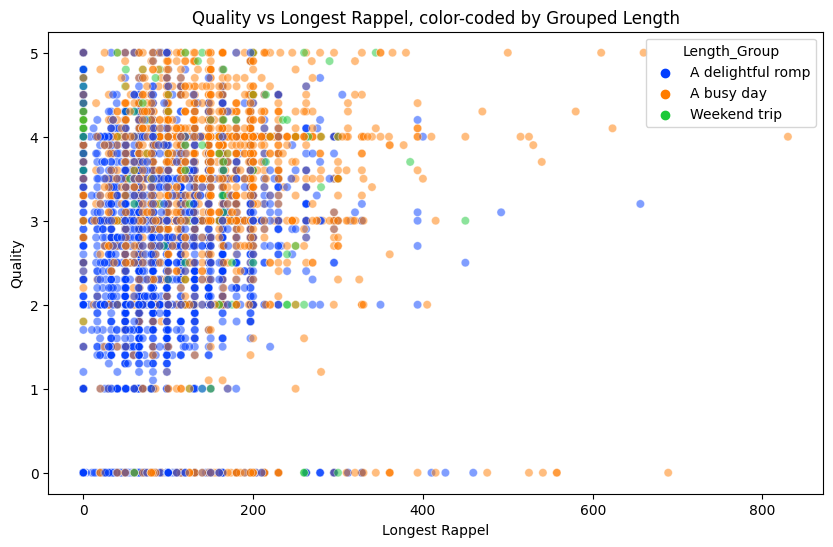

In [ ]:
group_mapping = {'I': 1, 'II': 1, 'III': 2, 'IV': 2, 'V': 3, 'VI': 3}
df_updated = df_export
# Apply the mapping to the 'Length' column to create the 'Length_Group' column
df_updated['Length_Group'] = df_updated['Length'].map(group_mapping)

# Create a scatterplot with dots
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(x='Longest', y='Quality', hue='Length_Group', palette='bright', alpha=.5, data=df_updated)

# Set plot title and labels
plt.title('Quality vs Longest Rappel, color-coded by Grouped Length')
plt.xlabel('Longest Rappel')
plt.ylabel('Quality')

# Get the current legend
legend = scatter.legend_

# Update the legend texts

legend.texts[0].set_text('A delightful romp')
legend.texts[1].set_text('A busy day')
legend.texts[2].set_text('Weekend trip')

plt.show()


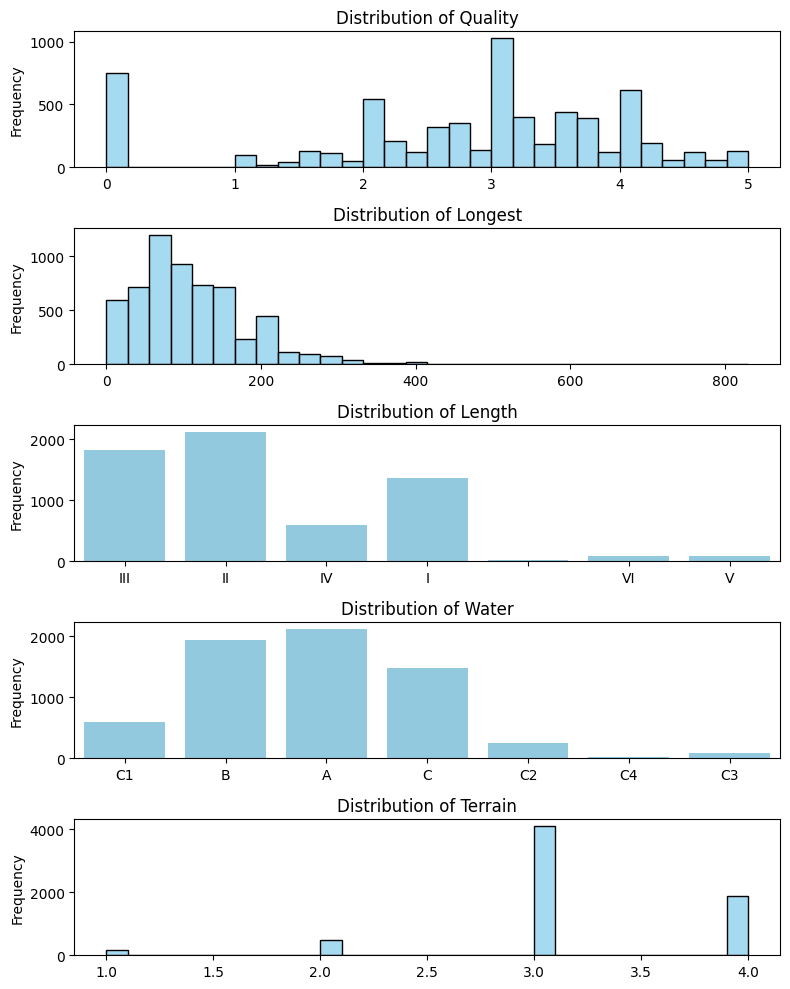

In [ ]:
df_improved = df_export

# Now we'll generate the visualizations for 'Longest', 'Quality', 'Length', 'Terrain', and 'Water'

# Create a list of the attributes we're interested in
attributes_improved = ['Quality', 'Longest', 'Length', 'Water', 'Terrain']

# Set up the matplotlib figure
f, axes = plt.subplots(len(attributes_improved), 1, figsize=(8, 10), sharex=False)

# Generate a histogram/distribution plot for each attribute
for ax, attribute in zip(axes, attributes_improved):
    if df_improved[attribute].dtype in ['int64', 'float64']:
        sns.histplot(df_improved[attribute].dropna(), kde=False, ax=ax, color='skyblue', bins=30)
    else:
        sns.countplot(x=df_improved[attribute].dropna(), ax=ax, color='skyblue')
    ax.set_title(f'Distribution of {attribute}')
    ax.set_xlabel('')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()


## Useful links
* canyons list: https://ropewiki.com/Category:Canyons
* Export pages as xml: https://ropewiki.com/index.php?title=Special:Export&action=submit
* Browse data?: https://ropewiki.com/Special:BrowseData/Canyons
* Access via PageID: https://ropewiki.com/index.php?curid=<PAGEIDHERE>

### Example json frrom repowiki_database.json

```
  {
    "URL": "http://ropewiki.com/The_Squeeze",
    "Name": "The Squeeze",
    "Quality": 4.75,
    "Popularity": 64,
    "Latitude": 38.5445,
    "Longitude": -110.9509,
    "Months": [
      "April",
      "May",
      "June",
      "July",
      "August",
      "September",
      "October",
      "November",
      "December"
    ],
    "Difficulty": "4b",
    "Vehicle": "4WD - High Clearance",
    "Shuttle": "None",
    "Permits": "No",
    "Sports": [
      "canyoneering"
    ],
    "Time": "IV",
    "RappelCountMin": 16,
    "RappelCountMax": 16,
    "RappelLengthMax": 99,
    "HTMLDescription": "<span class=\"mw-headline\" id=\"Introduction\">Introduction</span>\n\n<span class=\"mw-headline\" id=\"Approach\">Approach</span>\n\n<span class=\"mw-headline\" id=\"Descent\">Descent</span>\n\n<span class=\"mw-headline\" id=\"Exit\">Exit</span>\n\n<span class=\"mw-headline\" id=\"Red_tape\">Red tape</span>\n\n<span class=\"mw-headline\" id=\"Beta_sites\">Beta sites</span>\n\n<li> <img alt=\"\" src=\"/images/a/ac/Rwl_en.png\" width=\"16\" height=\"16\"><a rel=\"nofollow\" class=\"external text\" href=\"http://roadtripryan.com/go/t/utah/san-rafael-swell/squeezecanyon\">RoadTripRyan.com</a> &nbsp;: The Squeeze</li>\n<li> <img alt=\"\" src=\"/images/a/ac/Rwl_en.png\" width=\"16\" height=\"16\"><a rel=\"nofollow\" class=\"external text\" href=\"http://ropewiki.com/User:Super_Amazing_Map?id=The_Squeeze_-_San_Rafael_Swell\">Super Amazing Map</a> &nbsp;: The Squeeze</li>\n<li> <img alt=\"\" src=\"/images/a/ac/Rwl_en.png\" width=\"16\" height=\"16\"><a rel=\"nofollow\" class=\"external text\" href=\"http://climb-utah.com/SRS/squeeze1.htm\">Climb-Utah.com</a> &nbsp;: The Squeeze</li>\n<li> <img alt=\"\" src=\"/images/a/ac/Rwl_en.png\" width=\"16\" height=\"16\"><a rel=\"nofollow\" class=\"external text\" href=\"http://canyoncollective.com/betabase/the-squeeze-from-the-top-via-miners-trail.63\">CanyonCollective.com</a> &nbsp;: The Squeeze from the top via Miners Trail</li>\n<li> <img alt=\"\" src=\"/images/a/ac/Rwl_en.png\" width=\"16\" height=\"16\"><a rel=\"nofollow\" class=\"external text\" href=\"http://canyoneeringusa.com/images/stories/PDFs/Swell/MoroniSlopes/LowerSqueeze.pdf\">CanyoneeringUSA.com</a> &nbsp;: Lower Squeeze from Muddy Creek</li>\n\n<span class=\"mw-headline\" id=\"Trip_reports_and_media\">Trip reports and media</span>\n\n<li> <a rel=\"nofollow\" class=\"external text\" href=\"https://www.stavislost.com/hikes/trail/muddy-creek-and-overlook\">The Squeeze 2019-09-28 Stav is Lost</a></li>\n<li> <a rel=\"nofollow\" class=\"external text\" href=\"https://www.youtube.com/watch?v=Yz-8pqVUGiU\">Climb Utah Squeeze Video</a></li>\n<li> <a rel=\"nofollow\" class=\"external free\" href=\"https://www.facebook.com/pat.winstanley.7/media_set?set=a.714460858612614.1073741916.100001461198708&amp;type=3\">https://www.facebook.com/pat.winstanley.7/media_set?set=a.714460858612614.1073741916.100001461198708&amp;type=3</a></li>\n<li> <img alt=\"\" src=\"/images/a/ac/Rwl_en.png\" width=\"16\" height=\"16\"><a rel=\"nofollow\" class=\"external text\" href=\"http://candition.com/canyons/the-squeeze\">Candition.com</a> &nbsp;: The Squeeze</li>\n\n<span class=\"mw-headline\" id=\"Background\">Background</span>\n\n\n\n\n\n\n<h2><span class=\"mw-headline\" id=\"Credits\">Credits</span></h2>\n<div id=\"idcredits\" class=\"notranslate\" style=\"display:none\">The Squeeze</div>\n<div>Information provided by <span id=\"Pcredits\">automated processes</span>.  Main photo by <span id=\"Jcredits\">(unknown)</span>. Authors are listed in chronological order. <div id=\"fb-root\"></div><div class=\"fb-like\" data-href=\"http://ropewiki.com/The_Squeeze\" data-layout=\"standard\" data-action=\"like\" data-show-faces=\"true\" data-share=\"true\"></div></div>\n<div id=\"disclaimer\" style=\"font-size:0.75em\"><p>\nIn all habitats live animals and plants that deserve respect, please minimize impact on the environment and observe the local ethics. Canyoneering, Canyoning, Caving and other activities described in this site are inherently dangerous. Reliance on the information contained on this site is solely at your own risk. There is no warranty as to accuracy, timeliness or completeness of the information provided on this site. The site administrators and all the contributing authors expressly disclaim any and all liability for any loss or injury caused, in whole or in part, by its actions, omissions, or negligence in procuring, compiling or providing information through this site, including without limitation, liability with respect to any use of the information contained herein. If you notice any omission or mistakes, please contribute your knowledge (<a href=\"/Contributing\" title=\"Contributing\">more information</a>).</p></div>\n"
  },
```



 https://ropewiki.com/luca/rwr?gpx=off&kml=http://ropewiki.com/index.php/KMLList?limit=100&action=raw&templates=expand&ctype=application/x-zope-edit&num=on&numname=on&noloc=on&group=link&query=%5B%5BCategory%3ACanyons%5D%5D%5B%5BJump_Trip_%28Lower%29%5D%5D&sort=&order=&user=&list=&qname=&ext=.kml